In [1]:
%load_ext autoreload
%autoreload 2
import os
from scipy.misc import imread, imresize
import tensorflow as tf
import numpy as np

from scipy.misc import imread
from src.utils import preprocess_image, deprocess_image, load_image
import matplotlib.pyplot as plt

%matplotlib inline

def get_isession():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    # session = tf.Session(config=config)
    session = tf.InteractiveSession(config=config)
    return session

f:\awesome\win-env\.env\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Content Loss
A simple l2_norm could do the job (image - target), but it will make more sense to convert it from: $R^{1 \times H_l \times W_l \times C_l}$ to $R^{C_l \times N_l}$, where $\begin{equation} N_l = H_l \times W_l \end{equation}$, $l$ refers to layer number. The unrolled version of the image will be usefull for the style loss later

In [2]:
def content_loss(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    weight -- scalar constant we multiply the content_loss by
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(tf.transpose(a_C, perm=[3,1,2,0]), shape=[n_C, -1])
    a_G_unrolled = tf.reshape(tf.transpose(a_G, perm=[3,1,2,0]), shape=[n_C, -1])
    
    # compute the cost with tensorflow (≈1 line)
    J_content = tf.reduce_sum((a_C_unrolled - a_G_unrolled) ** 2)
    
    return J_content

In [3]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = content_loss(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 1298.9938


## Style Loss
For this the Gram Matrix is used as a way of measuring the statistical similarity between the current image and the target image. The result dimension of the Gram Matrix is $C_l \times C_l$

In [23]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    shape = tf.shape(A)

    return A @ tf.transpose(A) / tf.to_float(tf.reduce_prod(shape))

In [24]:
def layer_style_loss(a_S, a_G):
    """
    Arguments:
    weight -- scalar constant we multiply the content_loss by
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.reshape(tf.transpose(a_S, perm=[3,1,2,0]), shape=[n_C, -1])
    a_G = tf.reshape(tf.transpose(a_G, perm=[3,1,2,0]), shape=[n_C, -1])

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = tf.reduce_sum((GS - GG) ** 2) 
    
    return J_style_layer

In [25]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = layer_style_loss(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 36.76111


### Style layers
Multiple layers from the model will be merged for the final style loss, need to fine tune the weights.
To avoid calling model.layers[i] multiple times, gonna use the extract_features function to get them all at the beginning of everything, quite convinient but seemed weird to me the first time :/

In [26]:
def style_loss(layers, feats_S, feats_G):
    J_style = 0
    for layer, weight in layers:
        a_S, a_G = feats_S[layer], feats_G[layer]
        J_style += weight * layer_style_loss(a_S, a_G)
        
    return J_style

## Total-variation regularization
As stated in cs231n/assigment3, it's helpfull to add a term that penalizes wiggles in the pixel values. Compute it as the sum of squares of differences of each pair of pixels, in both dimensions for each input channels (RGB).

In [8]:
def tv_loss(img):
    """
    Compute total variation loss.
    
    Inputs:
    - weight: scalar number to use for the tv_loss
    - img: Tensor of shape (1, H, W, 3) holding an input image.
    
    Returns:
    - loss: Tensor holding a scalar giving the total variation loss
      for img weighted by tv_weight.
    """
    
    # Yay! no loops :3
    h = img[:,:-1,:,:]
    w = img[:,:,:-1,:]
    h_shifted = img[:,1:,:,:]
    w_shifted = img[:,:,1:,:]
    
    return tf.reduce_sum((h - h_shifted)[:,:,:-1,:]**2 + (w - w_shifted)[:,:-1,:,:] **2)

In [9]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    rgb = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_tv = tv_loss(rgb)
    
    print("J_style_layer = " + str(J_tv.eval()))

J_style_layer = 1656.3735


In [27]:
def total_cost(J_content, J_style, J_tv, alpha, beta, gamma):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    J_tv -- regularization cost
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    gamma -- hyperparameter weighting the importance of the regularization
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha * J_content + beta * J_style + gamma * J_tv
    
    return J

## Load Squeezenet
Use an interactive session, with gpu special options

In [11]:
from classifiers.squeezenet import SqueezeNet

In [28]:
MODEL_PATH = 'data/squeezenet.ckpt'

tf.reset_default_graph()
sess = get_isession()

if os.path.exists(MODEL_PATH):
    raise ValueError("You need to download SqueezeNet!")
model = SqueezeNet(save_path=MODEL_PATH, sess=sess)

f:\awesome\win-env\.env\lib\site-packages\tensorflow\python\client\session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from data/squeezenet.ckpt


## Trainning Loop
Extracts features from the 3 images: Generated, Content and Style, then combines the loss functions defined above and runs optimization :3

In [29]:
def style_transfer(content_image, style_image, image_size, style_size,
                   content_layer, style_layers, alpha, beta, gamma, init_random=False):
    """Run style transfer!
    
    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - style_layers: list of tuples (layer, weigth) to use for style loss
    - tv_weight: weight of total variation regularization term
    - model: SqueezeNet TF model
    - sess: TF session
    - init_random: initialize the starting image to uniform random noise
    """
    feats = model.extract_features(model.image)
    # extract feature from content image
    content_img = preprocess_image(load_image(content_image, size=image_size))
    content_features = sess.run(feats[content_layer],
                                {model.image: content_img[None]})
    
    # extract feature from content image
    style_img = preprocess_image(load_image(style_image, size=style_size))
    style_features = sess.run(feats,
                              {model.image: style_img[None]})
    
    # Initialize generated image to content image, should add some noise
    if init_random:
        img_var = tf.Variable(tf.random_uniform(content_img[None].shape, 0, 1), name="image")
    else:
        img_var = tf.Variable(content_img[None], name="image")

    # Extract features on generated image
    gen_features = model.extract_features(img_var)
    
    # Compute Loss
    c_loss = content_loss(content_features, gen_features[content_layer])
    s_loss = style_loss(style_layers, style_features, gen_features)
    t_loss = tv_loss(img_var)
    loss = total_cost(c_loss, s_loss, t_loss, alpha, beta, gamma)
    
    # Set up optimization hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180
    max_iter = 200
    
    # Create and initialize the Adam optimizer
    lr_var = tf.Variable(initial_lr, name="lr")
    # Create train_op that updates the generated image when run
    with tf.variable_scope("optimizer") as opt_scope:
        train_op = tf.train.AdamOptimizer(lr_var).minimize(loss, var_list=[img_var])
    # Initialize the generated image and optimization variables
    opt_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=opt_scope.name)
    sess.run(tf.variables_initializer([lr_var, img_var] + opt_vars))
    # Create an op that will clamp the image values when run
    clamp_image_op = tf.assign(img_var, tf.clip_by_value(img_var, -1.5, 1.5))
    
    f, axarr = plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style Source Img.')
    axarr[0].imshow(deprocess_image(content_img))
    axarr[1].imshow(deprocess_image(style_img))
    plt.show()
    plt.figure()
    
    # Hardcoded handcrafted 
    for t in range(max_iter):
        # Take an optimization step to update img_var
        sess.run(train_op)
        if t < decay_lr_at:
            sess.run(clamp_image_op)
        if t == decay_lr_at:
            sess.run(tf.assign(lr_var, decayed_lr))
        if t % 100 == 0:
            print('Iteration {}'.format(t))
            img = sess.run(img_var)
            plt.imshow(deprocess_image(img[0], rescale=True))
            plt.axis('off')
            plt.show()
    print('Iteration {}'.format(t))
    img = sess.run(img_var)        
    plt.imshow(deprocess_image(img[0], rescale=True))
    plt.axis('off')
    plt.show()

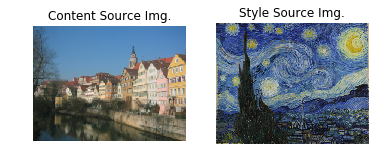

Iteration 0


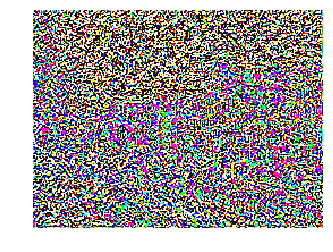

Iteration 100


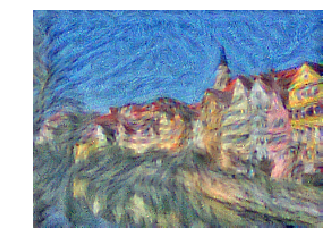

Iteration 199


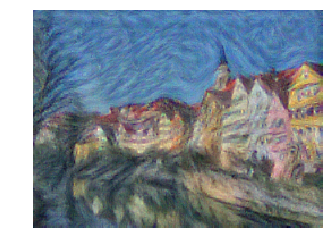

In [32]:
# Composition VII + Tubingen
params1 = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/starry_night.jpg',
    'image_size' : 192,
    'style_size' : 512,
    'content_layer' : 3,
    'alpha' : 5e-2,
    'beta' : 1,
    'gamma' : 5e-1,
    'style_layers' : [
        (1, 20000),
        (4, 500),
        (6, 12),
        (7, 1)
    ]
}

style_transfer(**params1)